## Tumor Segmentation with U-Net Networks

### Imports

In [1]:
# Imports ----------------------------------------------------------------------

# Common Python imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm

# Torch imports
import torch as th
# from torch.utils.data import DataLoader
from safetensors.torch import load_model, load_file

# Typining hints
from typing import List, Union, Callable, Tuple

# Change cwd to the parent directory and add it to the Python path
os.chdir("/home/marco/deep-learning-project/")
sys.path.append(os.getcwd())
print(f"Current working directory: {os.getcwd()}")

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.5,
		"grid.linewidth": 0.3,
	},
)

# Model import
from models.classic_unet import ClassicUNet
from models.improved_unet import ImprovedUNet
from models.attention_unet import AttentionUNet, VisualAttentionUNet

# Dataset loader
from utils.datasets import load_segmentation, load_single

# Utils imports
from utils.analysis import *
from utils.metrics import *


# Datasets directories (relative to the project root) --------------------------
DATASETS: str = "datasets"
SEGMENTATION: str = os.path.join(DATASETS, "segmentation/data")
# SAVE_PATH: str = "models/saved_models_128x128_n16"
SAVE_PATH: str = "models/saved_models"
SAVE_METRICS_PATH: str = "models/saved_metrics"


# Hyperparameters --------------------------------------------------------------
# NOTE: These must be the same of the training phase to load the model correctly
DEVICE_AUTODETECT: bool = True
PERCENTAGE: float = 0.5
SPLIT: int = 0.7
IMG_SIZE: int = 128
N_FILTERS: int = 32
BATCH_TRAIN: int = 64
BATCH_VALID: int = 64
EPOCHS: int = 10
CRITERION: Union[th.nn.Module, Callable[[th.Tensor, th.Tensor], th.Tensor]] = (
	th.nn.BCEWithLogitsLoss()
)
LR: float = 1e-3
WEIGHT_DECAY: float = 1e-2


# Device setup -----------------------------------------------------------------
device: th.device = th.device(
	"cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)
print(f"Using device: {device}")
if th.cuda.device_count() > 1: print(f"Using {th.cuda.device_count()} GPUs")

Current working directory: /home/marco/deep-learning-project
Using device: cpu


### Dataset

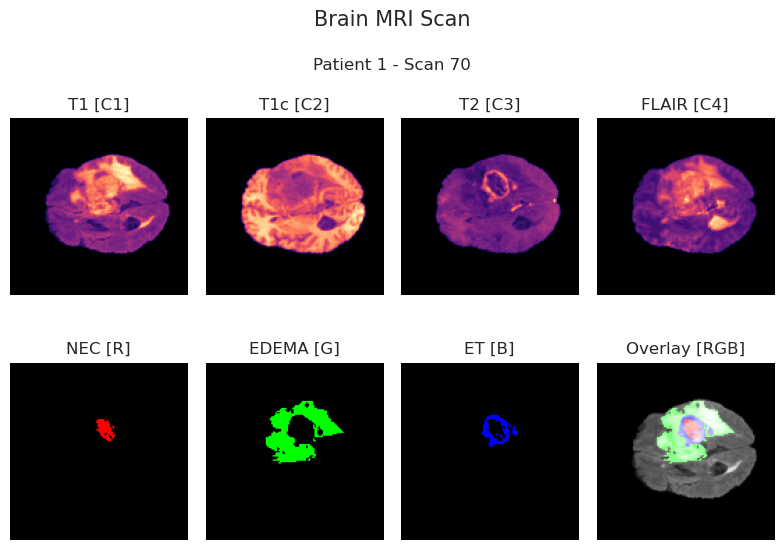

In [2]:
# View single patient ----------------------------------------------------------

# Patient's index
index: int = 1

# Scan index
scan: int = 70

# Load the patient's scans
images, masks = load_single(directory=SEGMENTATION, index=index, resize=(IMG_SIZE, IMG_SIZE))

# Plot the patient's scans
display_scan(scan, index, images, masks)

In [3]:
# # Animated gif of the scans (might take a while to generate)
# output_gif = display_animated(patient_index=1, 
#                               images=images, 
#                               masks=masks, 
#                               output_file='images/patient_scans.gif', scan_range=range(len(images)))
# display(output_gif)


In [4]:
# Load the BraTS2020 dataset ---------------------------------------------------

# Load the dataset
train_dataloader, valid_dataloader = load_segmentation(
	directory = SEGMENTATION,
	split = SPLIT,
	train_batch_size = BATCH_TRAIN,
	valid_batch_size = BATCH_VALID,
	percentage = PERCENTAGE,
	resize = (IMG_SIZE, IMG_SIZE),
	deterministic = True
)

# Count examples in the dataset
print(f"Total examples:      {len(train_dataloader.dataset) + len(valid_dataloader.dataset)} examples")
print(f"Train-Test split:    {SPLIT*100:.0f}% - {(1-SPLIT)*100:.0f}%") 
print(f"Train-Test examples: {len(train_dataloader.dataset)} - {len(valid_dataloader.dataset)}")

Total examples:      28413 examples
Train-Test split:    70% - 30%
Train-Test examples: 19889 - 8524


In [5]:
# # Sample a datapoint from the training dataset
# image, mask = next(iter(train_dataloader))

# # Choose a random index (between 0 - BATCH_TRAIN) to display that image
# index:int = np.random.randint(0, BATCH_TRAIN)

# # View images using plotting functions
# display_image_channels(image[index])
# display_mask_channels(mask[index])
# display_overlay(image[index], mask[index])

### U-Net Models

Define and load the trained model

In [6]:
# Select and initialize the U-Net model
classic_model: th.nn.Module = ClassicUNet(n_filters=N_FILTERS)
improved_model: th.nn.Module = ImprovedUNet(n_filters=N_FILTERS)
attention_model: th.nn.Module = AttentionUNet(n_filters=N_FILTERS)

# Move the model to the device
classic_model.to(device)
improved_model.to(device)
attention_model.to(device)

# Count the total number of parameters
classic_total_params = count_parameters(classic_model)
improved_total_params = count_parameters(improved_model)
attention_total_params = count_parameters(attention_model)

# Print the number of parameters
print(f"Classic U-Net total parameters:   {classic_total_params}")
print(f"Improved U-Net total parameters:  {improved_total_params}")
print(f"Attention U-Net total parameters: {attention_total_params}")

# Load the model from the saved checkpoint
saved_epoch: int = 10
classic_name: str = os.path.join(SAVE_PATH, f"{classic_model.module.name if isinstance(classic_model, th.nn.DataParallel) else classic_model.name}_e{saved_epoch}.pth")
improved_name: str = os.path.join(SAVE_PATH, f"{improved_model.module.name if isinstance(improved_model, th.nn.DataParallel) else improved_model.name}_e{saved_epoch}.pth")
attention_name: str = os.path.join(SAVE_PATH, f"{attention_model.module.name if isinstance(attention_model, th.nn.DataParallel) else attention_model.name}_e{saved_epoch}.pth")

# Load the state dictionary of trained parameters using safetensors
classic_state_dict = load_file(classic_name)
improved_state_dict = load_file(improved_name)
attention_state_dict = load_file(attention_name)

# Remove 'module.' prefix if it exists
# (this is necessary when using DataParallel wrapper in training
# and loading the model on a single device later)
classic_state_dict = remove_module_prefix(classic_state_dict)
improved_state_dict = remove_module_prefix(improved_state_dict)
attention_state_dict = remove_module_prefix(attention_state_dict)

# Load the trained parameters
classic_model.load_state_dict(classic_state_dict)
improved_model.load_state_dict(improved_state_dict)
attention_model.load_state_dict(attention_state_dict)

Classic U-Net total parameters:   5496451
Improved U-Net total parameters:  3082739
Attention U-Net total parameters: 3258263


<All keys matched successfully>

View model predictions

Performance metrics (%)
-----------------------------------------------------------
         Dice   IoU  Accuracy  FPR   FNR  Precision  Recall
Red     70.43 63.80     99.64 0.14 25.71      81.89   74.29
Green   59.33 49.54     99.33 0.23 39.89      73.79   60.11
Blue    39.29 25.97     99.65 0.05 71.01      71.43   28.99
Average 56.35 46.44     99.54 0.14 45.54      75.70   54.46


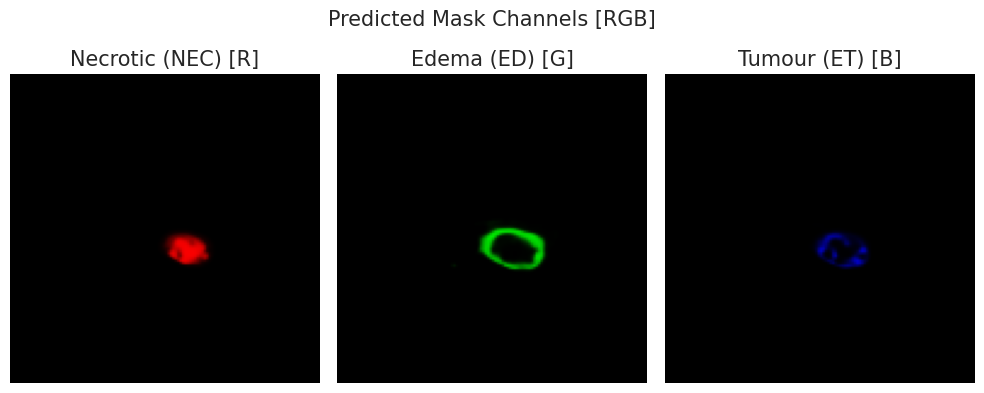

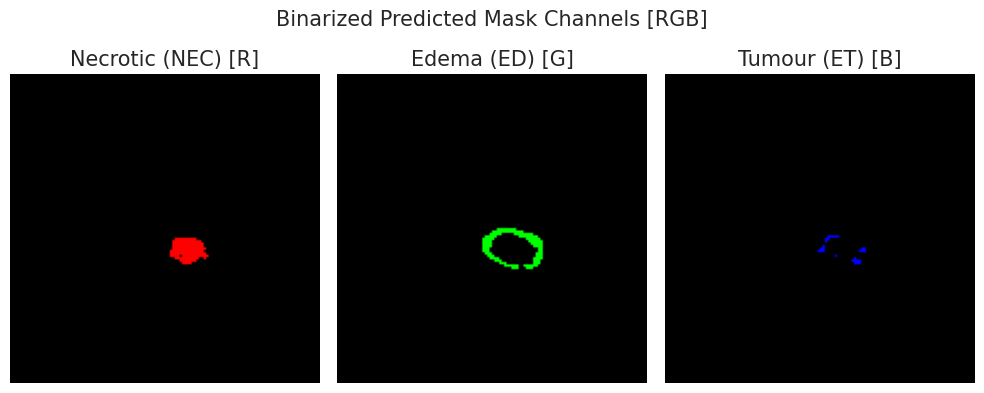

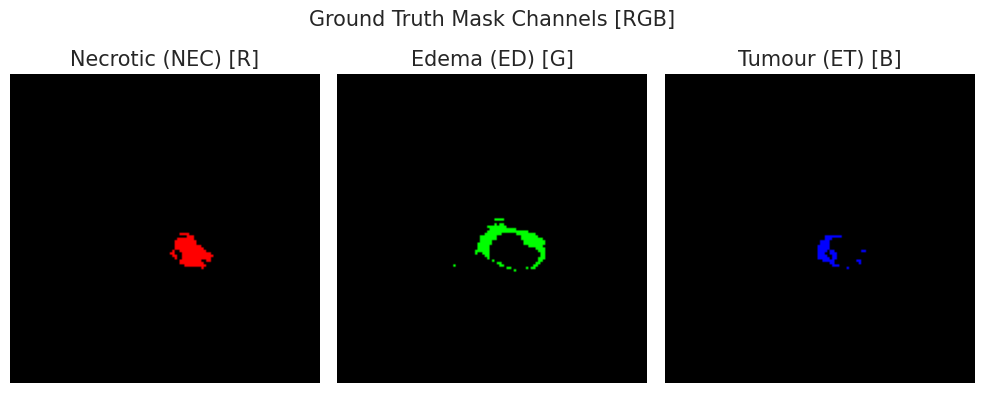

In [8]:
# Get an image from the validation dataset that the model hasn't been trained on
test_image, test_mask = next(iter(valid_dataloader))
index: int = np.random.randint(0, BATCH_VALID)

# Add batch dimension to the test image
test_image = test_image[index].unsqueeze(0)
test_mask = test_mask[index].unsqueeze(0)

# Get prediction and true mask
prediction = classic_model(test_image.to(device))
mask = test_mask.to(device)

# Compute metrics
dice_coeff = dice(prediction, mask)
iou_coeff = IoU(prediction, mask)
accuracy = accuracy2D(prediction, mask)
fpr = fpr2D(prediction, mask)
fnr = fnr2D(prediction, mask)
precision = precision2D(prediction, mask)
recall = recall2D(prediction, mask)

# Convert metrics to percentage format
dice_coeff = [score * 100 for score in dice_coeff]
iou_coeff = [score * 100 for score in iou_coeff]
accuracy = [score * 100 for score in accuracy]
fpr = [score * 100 for score in fpr]
fnr = [score * 100 for score in fnr]
precision = [score * 100 for score in precision]
recall = [score * 100 for score in recall]

# Create a DataFrame to display the metrics
metrics = {
	'Dice': dice_coeff,
	'IoU': iou_coeff,
	'Accuracy': accuracy,
	'FPR': fpr,
	'FNR': fnr,
	'Precision': precision,
	'Recall': recall,
}
rows = ['Red', 'Green', 'Blue', 'Average']
df = pd.DataFrame(metrics, index=rows)
pd.options.display.float_format = '{:.2f}'.format

print("Performance metrics (%)")
print("-----------------------------------------------------------")
print(df)

# Display the prediction
display_prediction(classic_model, test_image, test_mask, device=device)

### Performance Assessment

In [8]:
# Load the metrics dataframes from csv file
classic_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{classic_model.module.name if isinstance(classic_model, th.nn.DataParallel) else classic_model.name}_e{saved_epoch}.csv"))
improved_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{improved_model.module.name if isinstance(improved_model, th.nn.DataParallel) else improved_model.name}_e{saved_epoch}.csv"))
attention_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{attention_model.module.name if isinstance(attention_model, th.nn.DataParallel) else attention_model.name}_e{saved_epoch}.csv"))

In [9]:
# Visualize tables
display(classic_df)
display(improved_df)
display(attention_df)

,epoch,train_loss,validation_loss,dice_red,dice_green,dice_blue,dice_average,iou_red,iou_green,iou_blue,...,fnr_blue,fnr_average,precision_red,precision_green,precision_blue,precision_average,recall_red,recall_green,recall_blue,recall_average
0,1,11.824981,2.253795,0.081047,0.201774,0.063327,0.115383,0.000000,0.000568,0.000000,...,0.441426,0.533950,0.000000,0.094666,0.000000,0.031555,0.000000,0.000568,0.000000,0.000189
1,2,4.636117,1.790482,0.099369,0.280610,0.127135,0.169038,0.040541,0.247938,0.071756,...,0.361230,0.376997,0.112519,0.376896,0.203858,0.231091,0.048249,0.342982,0.080196,0.157142
2,3,3.914954,1.555767,0.131404,0.305260,0.195508,0.210724,0.094482,0.293060,0.179188,...,0.227019,0.289986,0.201972,0.442017,0.297378,0.313789,0.118810,0.399241,0.214407,0.244153
3,4,3.347853,1.298053,0.161262,0.346917,0.242845,0.250341,0.140565,0.316739,0.222211,...,0.177888,0.258624,0.239320,0.476766,0.320417,0.345501,0.179953,0.383054,0.263538,0.275515
4,5,2.867144,1.131008,0.192242,0.374286,0.262793,0.276440,0.180828,0.342738,0.245114,...,0.135793,0.224573,0.267711,0.509733,0.316953,0.364799,0.221069,0.401996,0.305632,0.309566
5,6,2.429915,0.949760,0.205647,0.421293,0.276753,0.301231,0.179271,0.390750,0.257310,...,0.133874,0.210053,0.293911,0.511136,0.333383,0.379477,0.196676,0.468031,0.307552,0.324086
6,7,2.087246,0.840293,0.236323,0.435248,0.290539,0.320703,0.219952,0.400388,0.275916,...,0.094456,0.179623,0.299954,0.541318,0.323039,0.388104,0.256165,0.460412,0.346970,0.354516
7,8,1.932537,0.769410,0.237440,0.453851,0.294171,0.328487,0.219739,0.426079,0.280992,...,0.099144,0.173819,0.312221,0.545392,0.335128,0.397580,0.243452,0.495226,0.342282,0.360320
8,9,1.727241,0.707008,0.251905,0.464659,0.299348,0.338637,0.238867,0.432361,0.285375,...,0.106126,0.167057,0.308148,0.560323,0.345412,0.404628,0.278863,0.487086,0.335299,0.367083
9,10,1.589656,0.729579,0.248185,0.482941,0.306899,0.346008,0.220449,0.452300,0.286856,...,0.110391,0.157614,0.322253,0.521074,0.349150,0.397492,0.237549,0.560993,0.331035,0.376526


,epoch,train_loss,validation_loss,dice_red,dice_green,dice_blue,dice_average,iou_red,iou_green,iou_blue,...,fnr_blue,fnr_average,precision_red,precision_green,precision_blue,precision_average,recall_red,recall_green,recall_blue,recall_average
0,1,11.939721,1.570849,0.098667,0.342532,0.116498,0.185899,0.000000,0.322972,0.000000,...,0.441426,0.402108,0.000000,0.464996,0.000000,0.154999,0.000000,0.396095,0.000000,0.132032
1,2,2.651109,0.887958,0.225200,0.429388,0.263891,0.306160,0.212193,0.402867,0.239431,...,0.175631,0.204125,0.285603,0.532843,0.346238,0.388228,0.256778,0.467469,0.265795,0.330014
2,3,1.840057,0.756352,0.246406,0.458567,0.292528,0.332500,0.229407,0.433343,0.274408,...,0.124109,0.169762,0.317389,0.529543,0.344072,0.397001,0.258194,0.517621,0.317317,0.364377
3,4,1.542737,0.708002,0.269342,0.464755,0.309902,0.348000,0.252884,0.423797,0.291364,...,0.116175,0.168565,0.306523,0.578690,0.364295,0.416503,0.310603,0.460868,0.325250,0.365574
4,5,1.393828,0.558580,0.281215,0.502147,0.323664,0.369009,0.262995,0.471164,0.305785,...,0.088811,0.144833,0.342022,0.579036,0.355464,0.425507,0.288834,0.526471,0.352615,0.389307
5,6,1.267959,0.575305,0.285763,0.495544,0.324320,0.368542,0.267260,0.451987,0.307938,...,0.082003,0.154195,0.343047,0.595154,0.351522,0.429908,0.294350,0.486058,0.359423,0.379944
6,7,1.199392,0.540797,0.289650,0.517105,0.330531,0.379095,0.271639,0.489104,0.315560,...,0.074931,0.119809,0.346737,0.559663,0.357182,0.421194,0.297128,0.579368,0.366495,0.414330
7,8,1.121713,0.533601,0.293336,0.515420,0.338080,0.382278,0.270979,0.467681,0.319415,...,0.078715,0.149155,0.351740,0.607893,0.364956,0.441530,0.290606,0.501637,0.362710,0.384984
8,9,1.061639,0.485066,0.294097,0.526482,0.339728,0.386769,0.269195,0.493352,0.320642,...,0.069350,0.131876,0.352574,0.590046,0.358055,0.433558,0.290217,0.544499,0.372076,0.402264
9,10,1.030427,0.472680,0.306066,0.541310,0.334922,0.394099,0.288845,0.512758,0.311650,...,0.109219,0.113655,0.328853,0.587230,0.388513,0.434865,0.348692,0.580555,0.332207,0.420485


,epoch,train_loss,validation_loss,dice_red,dice_green,dice_blue,dice_average,iou_red,iou_green,iou_blue,...,fnr_blue,fnr_average,precision_red,precision_green,precision_blue,precision_average,recall_red,recall_green,recall_blue,recall_average
0,1,13.787278,1.601052,0.098250,0.351898,0.119313,0.189820,0.000000,0.328509,0.000000,...,0.441426,0.393933,0.000000,0.447075,0.000000,0.149025,0.000000,0.420619,0.000000,0.140206
1,2,2.925784,0.967156,0.207039,0.430609,0.253151,0.296933,0.188065,0.396599,0.224406,...,0.194485,0.224399,0.283186,0.524628,0.351704,0.386506,0.217466,0.464814,0.246940,0.309740
2,3,1.903992,0.719075,0.255354,0.469826,0.302550,0.342577,0.244632,0.441726,0.281551,...,0.117073,0.154469,0.312400,0.539993,0.348985,0.400459,0.290598,0.524060,0.324353,0.379670
3,4,1.556162,0.638785,0.268539,0.482692,0.311013,0.354082,0.251794,0.445499,0.296464,...,0.102506,0.163506,0.332317,0.575097,0.356191,0.421202,0.278386,0.494593,0.338920,0.370633
4,5,1.347802,0.565741,0.285383,0.503314,0.319089,0.369262,0.271601,0.469176,0.295419,...,0.122624,0.146964,0.328449,0.570794,0.376753,0.425332,0.315405,0.527321,0.318801,0.387176
5,6,1.238118,0.546205,0.289239,0.514310,0.332583,0.378710,0.267315,0.485482,0.313009,...,0.081893,0.125418,0.348060,0.555968,0.359307,0.421112,0.290136,0.576495,0.359532,0.408721
6,7,1.159884,0.506117,0.297558,0.526416,0.337264,0.387079,0.280179,0.499923,0.320368,...,0.074670,0.111129,0.349521,0.559269,0.364222,0.424338,0.308831,0.593444,0.366756,0.423010
7,8,1.077670,0.498333,0.303713,0.521537,0.336637,0.387296,0.285791,0.486396,0.317146,...,0.097556,0.131758,0.341347,0.594019,0.381929,0.439098,0.325312,0.537962,0.343870,0.402381
8,9,1.052496,0.497439,0.304788,0.533930,0.339243,0.392653,0.287863,0.507829,0.321238,...,0.088916,0.105313,0.348359,0.558430,0.377859,0.428216,0.321822,0.612146,0.352510,0.428826
9,10,0.994960,0.431881,0.309585,0.547042,0.344946,0.400524,0.293111,0.518628,0.327791,...,0.075714,0.111003,0.355551,0.596554,0.372888,0.441665,0.323317,0.580380,0.365712,0.423136


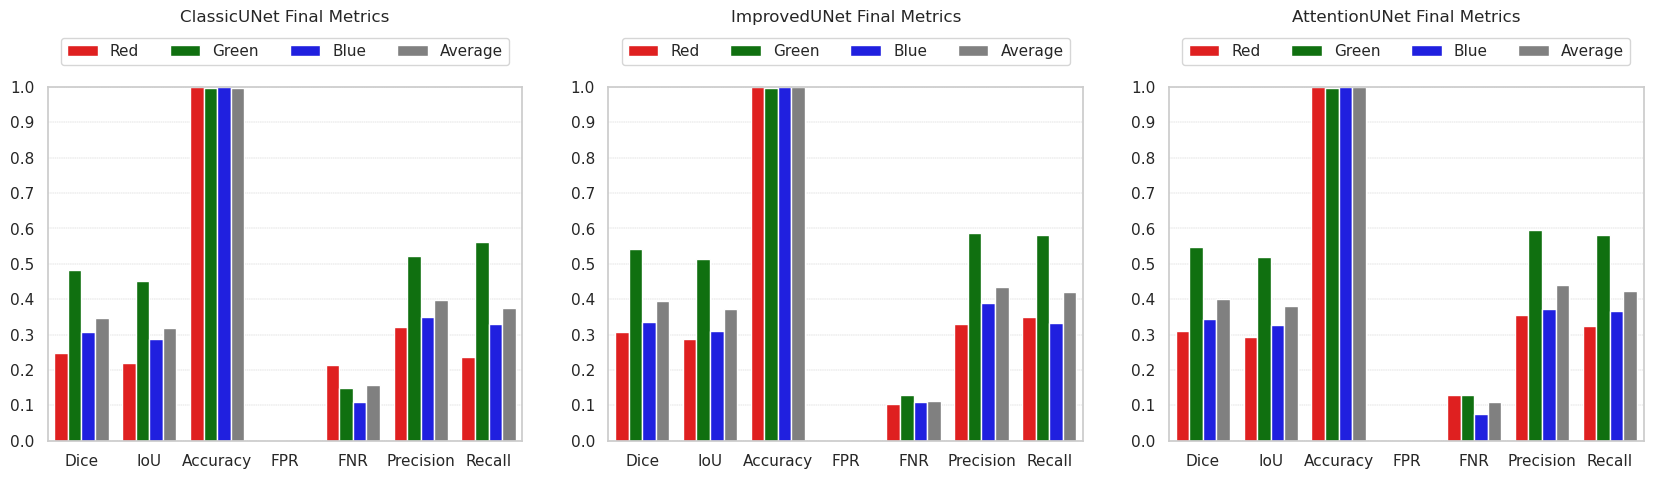

In [10]:
barplot_metrics_multiple([classic_df, improved_df, attention_df], [classic_model, improved_model, attention_model])

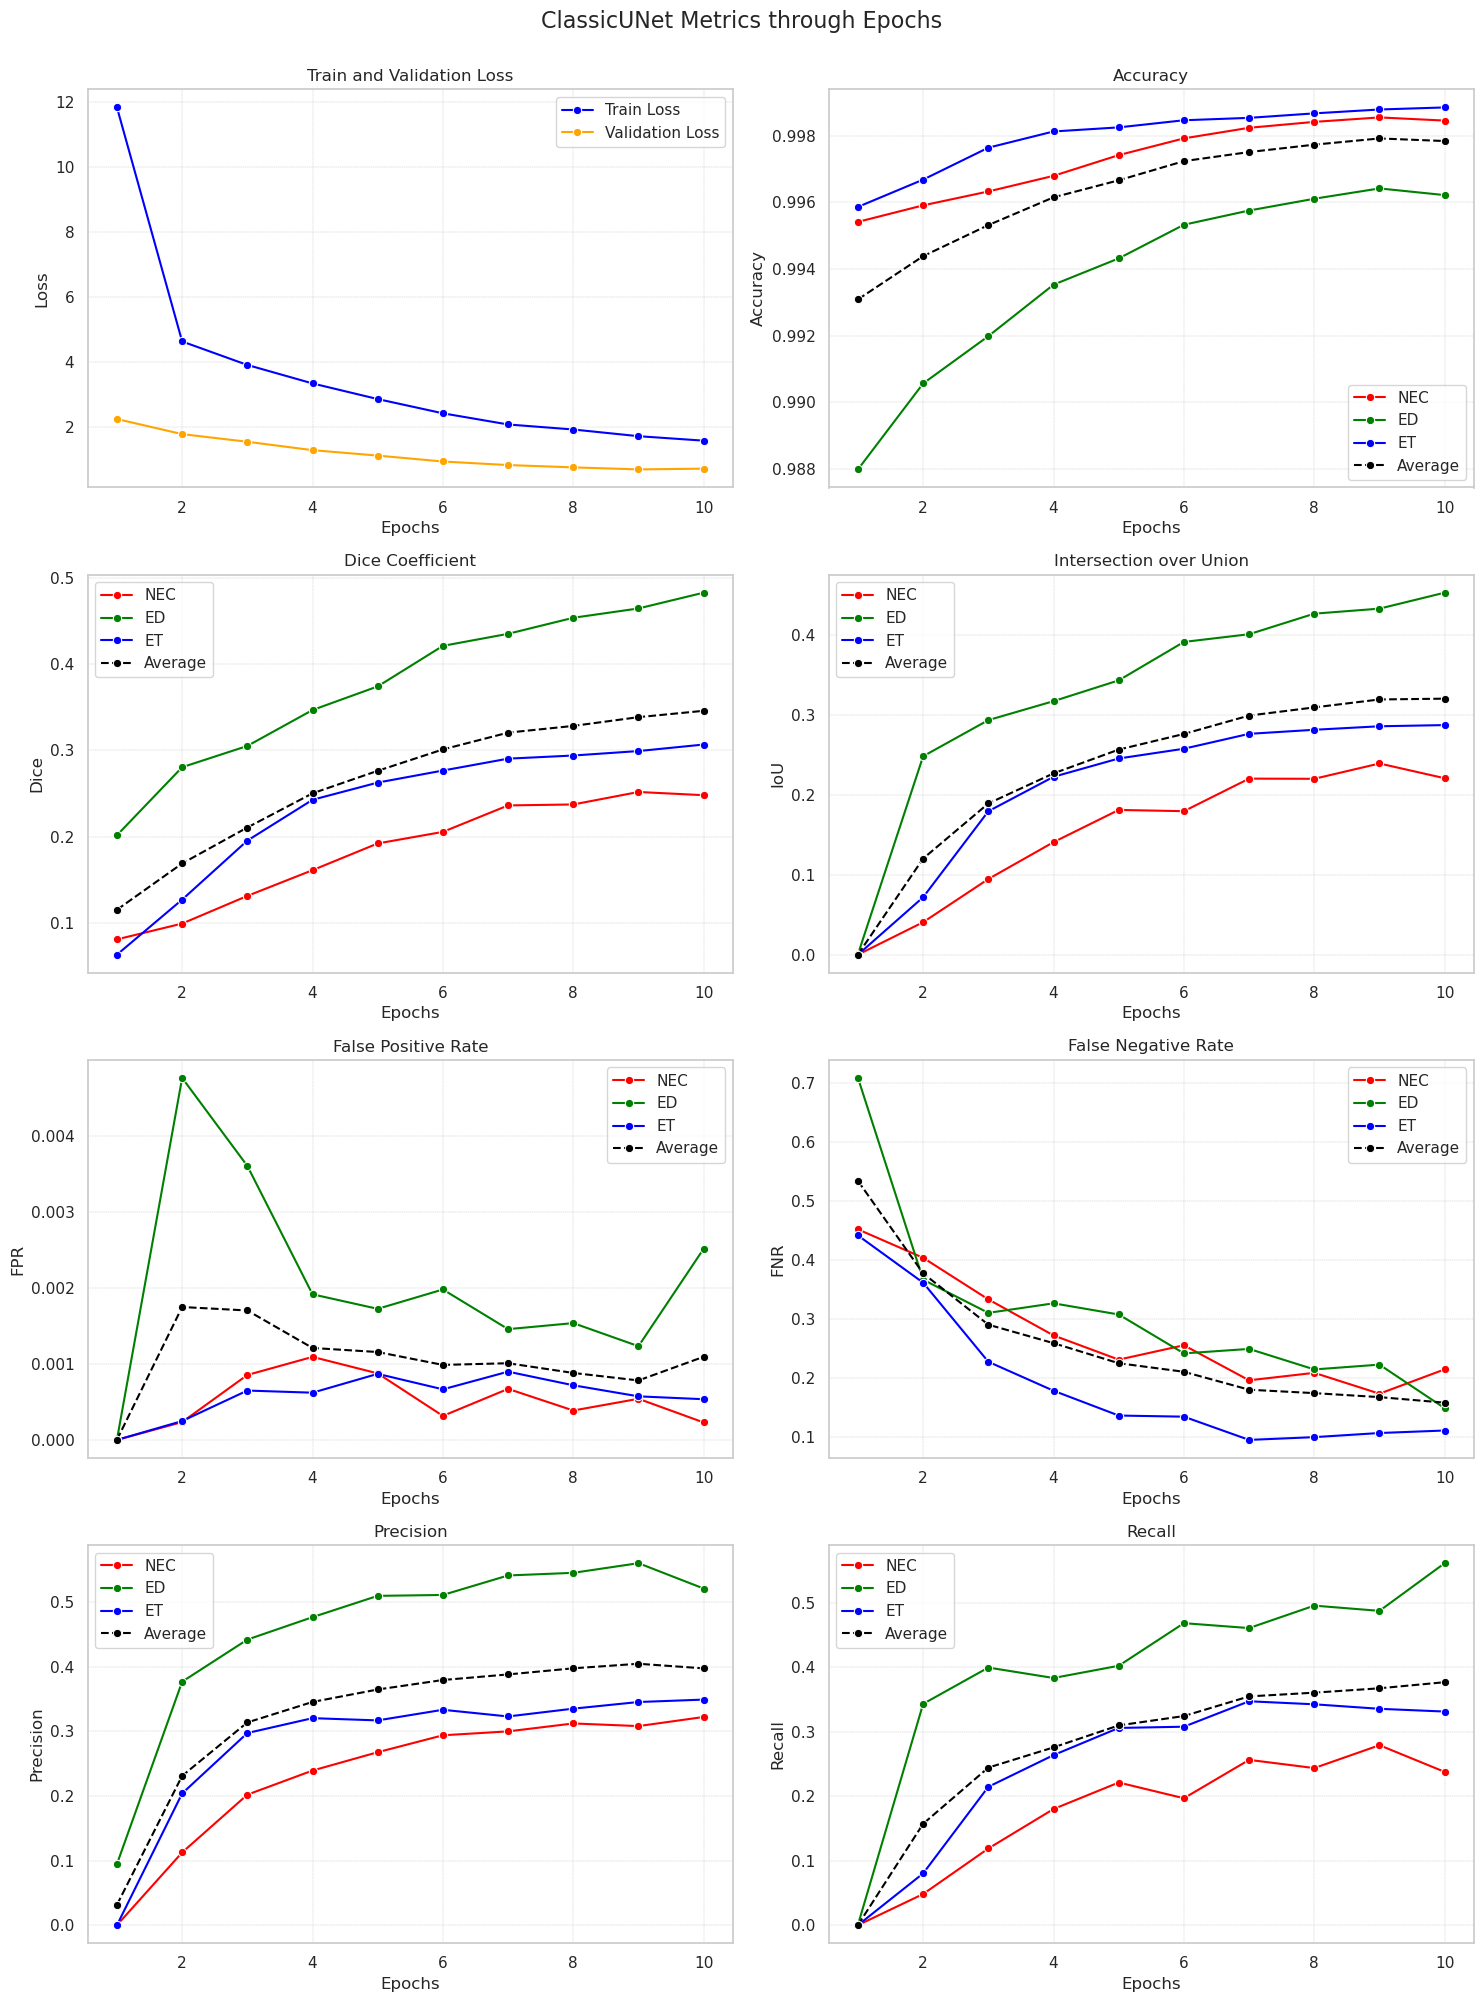

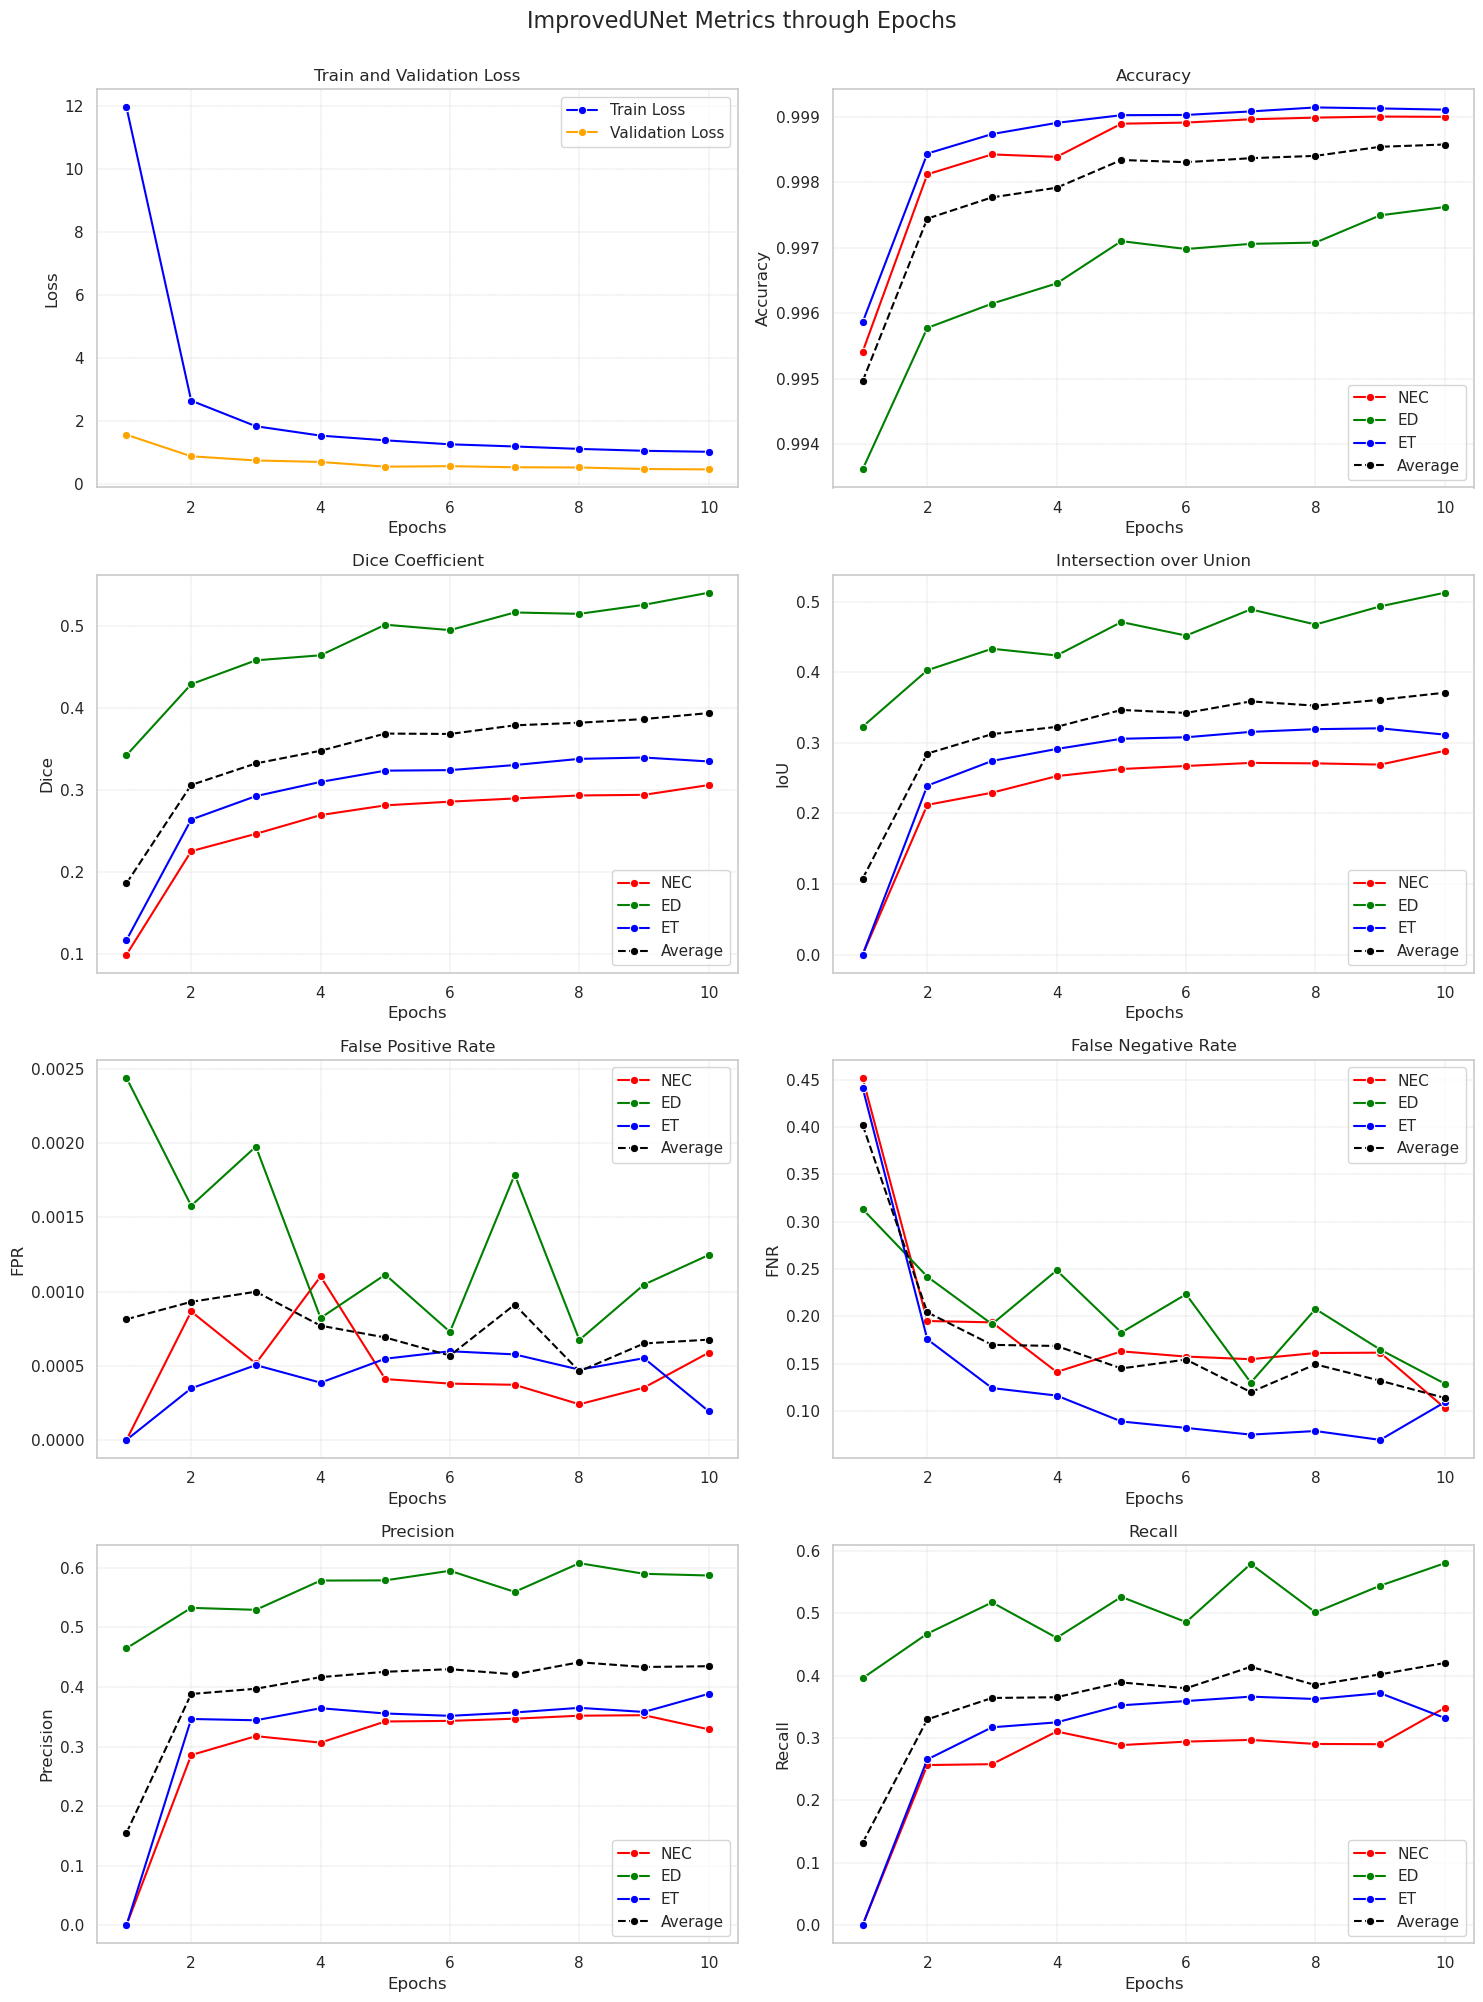

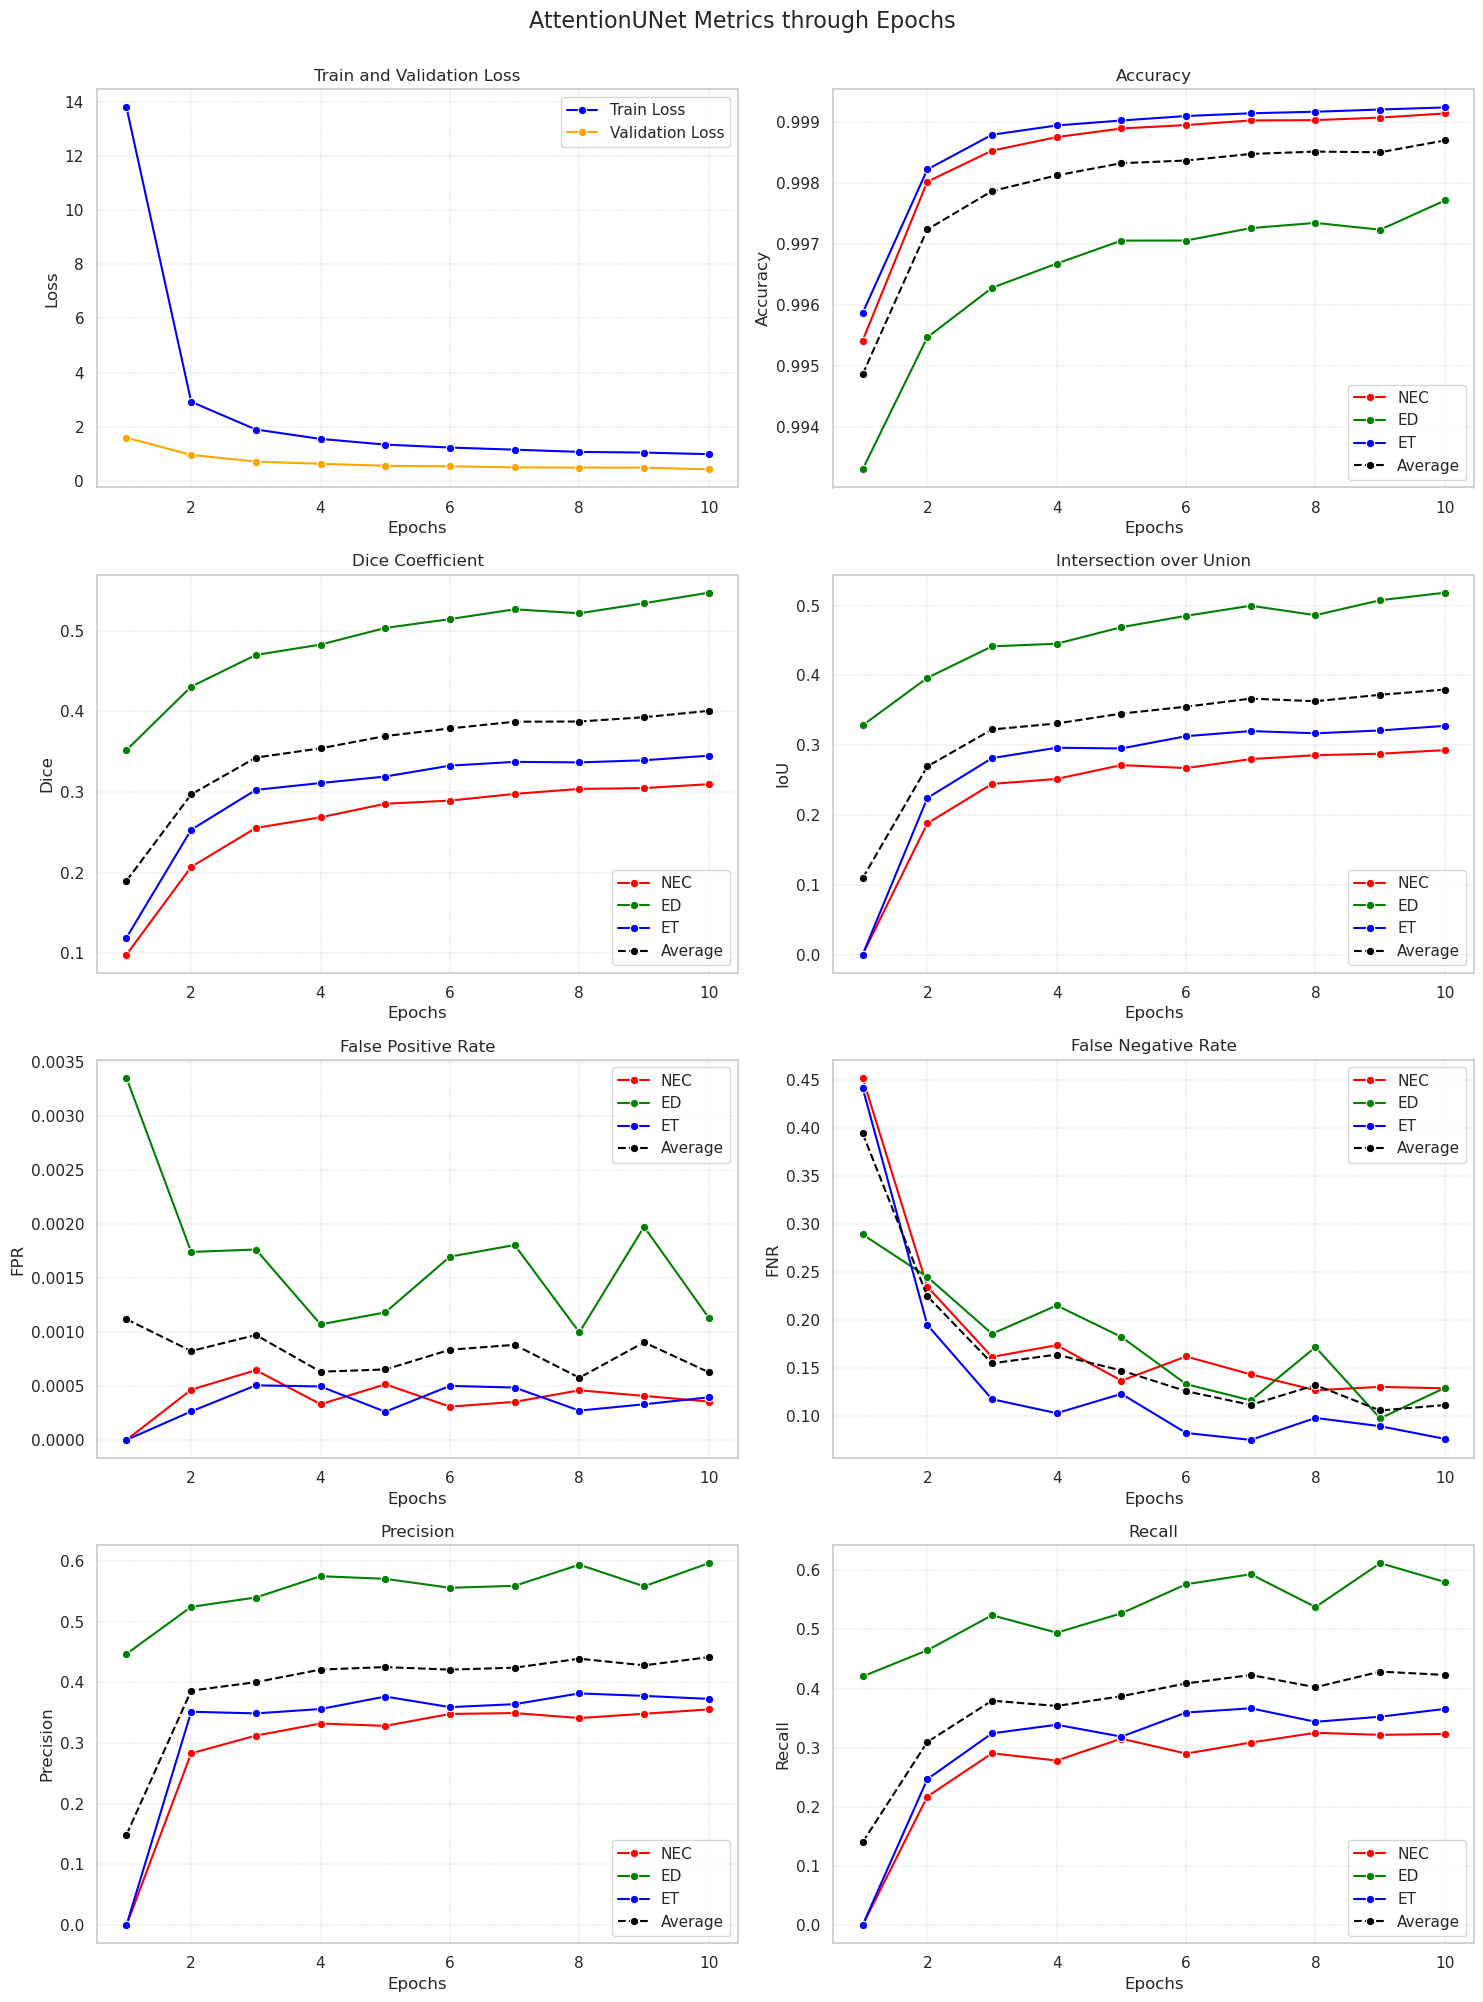

In [11]:
# Plot metrics vs epochs
plot_metrics(classic_df, classic_model)
plot_metrics(improved_df, improved_model)
plot_metrics(attention_df, attention_model)

### Visualize Attention Blocks

In [14]:
# Load the visual model

visual_model: th.nn.Module = VisualAttentionUNet(n_filters=N_FILTERS)

# Move the model to the device
visual_model.to(device)

# Load the model from the saved checkpoint
saved_epoch: int = 10
attention_name: str = os.path.join(SAVE_PATH, f"{visual_model.module.name if isinstance(visual_model, th.nn.DataParallel) else visual_model.name}_e{saved_epoch}.pth")

# Load the state dictionary of trained parameters using safetensors
attention_state_dict = load_file(attention_name)

# Remove 'module.' prefix if it exists
attention_state_dict = remove_module_prefix(attention_state_dict)

# Load the trained parameters
visual_model.load_state_dict(attention_state_dict)

<All keys matched successfully>

map_4 shape: torch.Size([1, 1, 8, 8])
map_3 shape: torch.Size([1, 1, 16, 16])
map_2 shape: torch.Size([1, 1, 32, 32])
map_1 shape: torch.Size([1, 1, 64, 64])
att_map shape after squeeze: (8, 8)
att_map shape after squeeze: (16, 16)
att_map shape after squeeze: (32, 32)
att_map shape after squeeze: (64, 64)


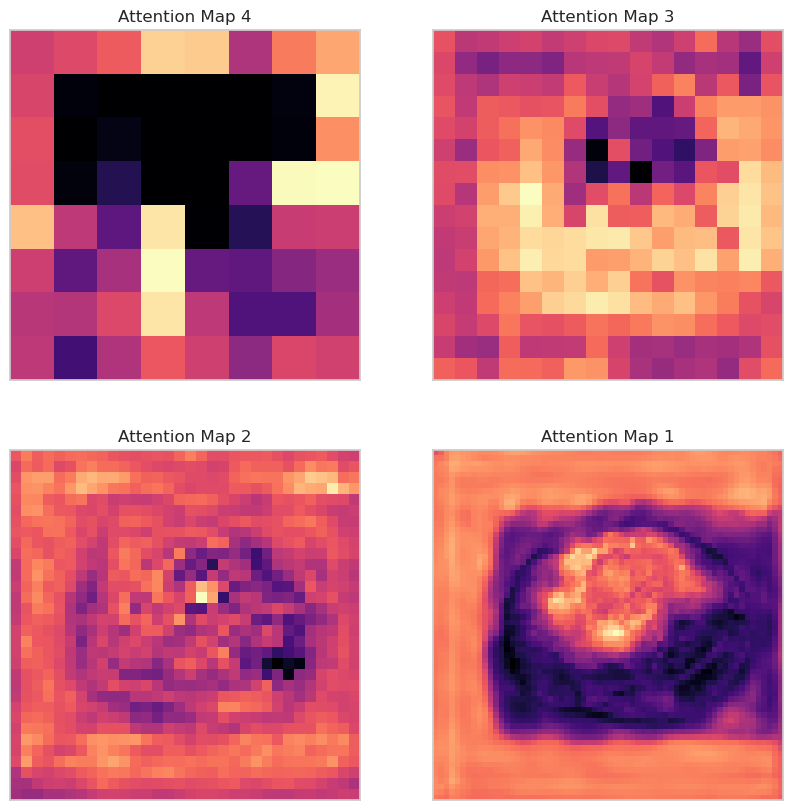

In [35]:
# Patient's index
index: int = 1

# Scan index
scan: int = 70

# Load the patient's scans
images, masks = load_single(directory=SEGMENTATION, index=index, resize=(IMG_SIZE, IMG_SIZE))
image = images[scan].unsqueeze(0)

# Forward pass to get attention maps
_, map_1, map_2, map_3, map_4 = visual_model(image.to(device))

# Print shapes of attention maps
print(f'map_4 shape: {map_4.shape}')
print(f'map_3 shape: {map_3.shape}')
print(f'map_2 shape: {map_2.shape}')
print(f'map_1 shape: {map_1.shape}')

# display_image_channels(images[scan])
# display_mask_channels(masks[scan])

# Plot attention maps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for idx, (ax, att_map) in enumerate(zip(axes.flatten(), [map_4, map_3, map_2, map_1])):
	# power = 2**(3 - idx)
	# ax.imshow(att_map.detach().cpu().numpy().reshape(120//power,120//power), cmap='magma')
	att_map = att_map.detach().cpu().numpy().squeeze()  # Remove batch and channel dimensions
	print(f'att_map shape after squeeze: {att_map.shape}')
	ax.imshow(att_map, cmap='magma')
	ax.xaxis.set_visible(False)
	ax.yaxis.set_visible(False)
	ax.set_title(f'Attention Map {4-idx}')
	ax.grid(False)